In [1]:
# For Google Colab 
#!git clone https://github.com/Mikolaj-MLP/NLP-Sentiment-IMDB-reviews.git
#import sys
#sys.path.append('/content/NLP-Sentiment-IMDB-reviews')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
import os

In [3]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
train = pd.read_csv(r"C:\Users\mikol\OneDrive\Pulpit\Data\IMDB reviews\Train.csv")
test = pd.read_csv(r"C:\Users\mikol\OneDrive\Pulpit\Data\IMDB reviews\Test.csv")
valid = pd.read_csv(r"C:\Users\mikol\OneDrive\Pulpit\Data\IMDB reviews\Valid.csv")

In [5]:
train.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [6]:
def print_wrapped_text(text, words_per_line):
    words = text.split()
    for i in range(0, len(words), words_per_line):
        print(" ".join(words[i:i + words_per_line]))

In [7]:
row = 1
text = f"{train['text'][row]}\nSentiment: {train['label'][row]}"
print_wrapped_text(text, 25)

When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping
that this movie would contain some of the strong-points of the first movie: Awsome animation, good flowing story, excellent voice cast, funny comedy and a
kick-ass soundtrack. But, to my disappointment, not any of this is to be found in Atlantis: Milo's Return. Had I read some reviews first, I
might not have been so let down. The following paragraph will be directed to those who have seen the first movie, and who enjoyed it
primarily for the points mentioned.<br /><br />When the first scene appears, your in for a shock if you just picked Atlantis: Milo's Return from the
display-case at your local videoshop (or whatever), and had the expectations I had. The music feels as a bad imitation of the first movie, and
the voice cast has been replaced by a not so fitting one. (With the exception of a few characters, like the voice of Sweet). The
actual drawings isnt that bad, b

In [8]:
print(train.shape)
print(test.shape)
print(valid.shape)

column = "label"
print("\nunique labels :", train[column].unique(), valid[column].unique(), test[column].unique())

print("\nnull count : \n", train.isnull().sum(), valid.isnull().sum(), test.isnull().sum())

(40000, 2)
(5000, 2)
(5000, 2)

unique labels : [0 1] [0 1] [0 1]

null count : 
 text     0
label    0
dtype: int64 text     0
label    0
dtype: int64 text     0
label    0
dtype: int64


Data Preprocessing

In [9]:
from utils.data_preprocessor import DataPreprocessor

In [10]:
preprocessor = DataPreprocessor(remove_stopwords=True, use_stemming=True)

In [11]:
train_processed, valid_processed, test_processed = preprocessor.process((train, valid, test))

In [12]:
all_tokens = [token for row in train_processed['processed_text'] for token in row]

word_freq = Counter(all_tokens)
unique_words = len(word_freq)
vocab_size = len(set(all_tokens))

In [13]:
train_processed

,processed_text,label
0,"[grew, b, watch, love, thunderbird, mate, scho...",0
1,"[put, movi, dvd, player, sat, coke, chip, expe...",0
2,"[peopl, know, particular, time, past, like, fe...",0
3,"[even, though, great, interest, biblic, movi, ...",0
4,"[im, die, hard, dad, armi, fan, noth, ever, ch...",1
...,...,...
39995,"[western, union, someth, forgotten, classic, w...",1
39996,"[movi, incred, piec, work, explor, everi, nook...",1
39997,"[wife, watch, movi, plan, visit, sicili, strom...",0
39998,"[first, watch, flatlin, amaz, necessari, featu...",1


Data Analysis

In [14]:
print(train_processed['processed_text'].apply(len).mean())

118.1877


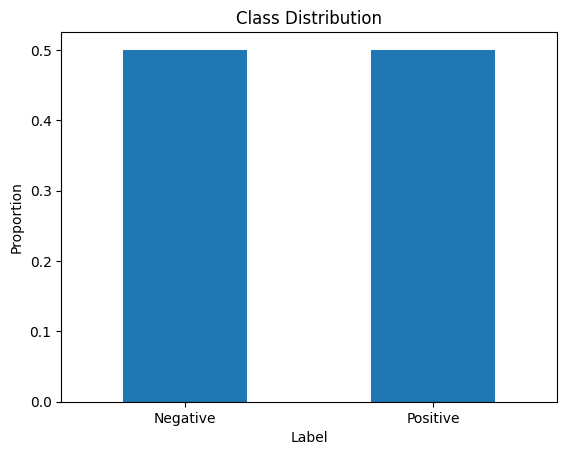

In [15]:
train_processed['label'].value_counts(normalize=True).plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"], rotation=0)
plt.show()

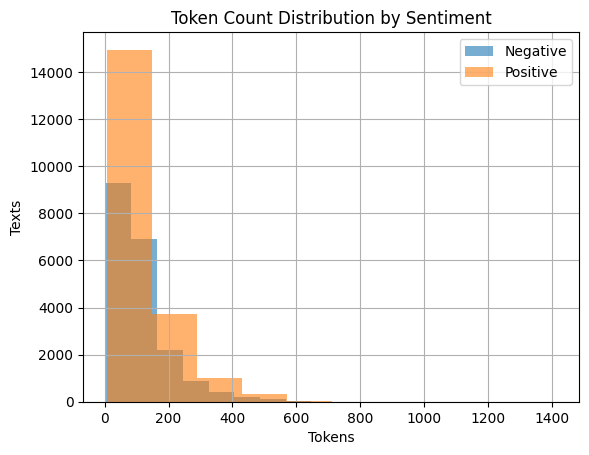

In [16]:
train_processed['length'] = train_processed['processed_text'].apply(len)

train_processed[train_processed['label'] == 0]['length'].hist(alpha=0.6, label='Negative')
train_processed[train_processed['label'] == 1]['length'].hist(alpha=0.6, label='Positive')
plt.legend()
plt.title("Token Count Distribution by Sentiment")
plt.xlabel("Tokens")
plt.ylabel("Texts")
plt.show()

In [17]:
def top_words_for_label(label, n=15):
    tokens = train_processed[train_processed['label'] == label]['processed_text'].explode()
    return Counter(tokens).most_common(n)

print("Positive (label=1):", top_words_for_label(1))
print("Negative (label=0):", top_words_for_label(0))

Positive (label=1): [('film', 40687), ('movi', 36010), ('one', 22660), ('like', 16602), ('time', 13326), ('good', 12221), ('see', 12180), ('charact', 11332), ('stori', 11324), ('make', 11135), ('great', 10500), ('well', 10473), ('watch', 10313), ('get', 10257), ('love', 10105)]
Negative (label=0): [('movi', 46777), ('film', 36001), ('one', 21722), ('like', 19715), ('make', 12977), ('even', 12371), ('time', 12320), ('get', 12222), ('good', 12051), ('watch', 11980), ('bad', 11781), ('charact', 11402), ('would', 11185), ('see', 10436), ('realli', 9899)]


In [18]:
#junk seeking, here we examine the validity of the cleaning process to make sure some illogical symbols have not remained
print("Bottom 10 Words by Frequency:", word_freq.most_common()[-10:])

rare_words = [(word, count) for word, count in word_freq.items() if count < 5]
print(f"Rare Words (<5 occurrences): {len(rare_words)}")
print("Sample:", rare_words[:10])

Bottom 10 Words by Frequency: [('aaghh', 1), ('hyller', 1), ('entirelli', 1), ('igeni', 1), ('csiko', 1), ('puszta', 1), ('paedophiliac', 1), ('amnes', 1), ('golthwait', 1), ('onso', 1)]
Rare Words (<5 occurrences): 39781
Sample: [('jonatha', 1), ('subsp', 1), ('videoshop', 1), ('schoobi', 3), ('nuttin', 2), ('moonland', 1), ('ipso', 1), ('audiobook', 1), ('mcneali', 3), ('microsystem', 1)]


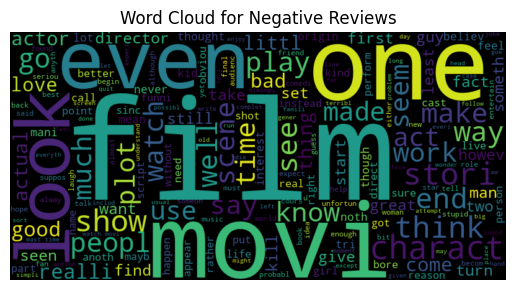

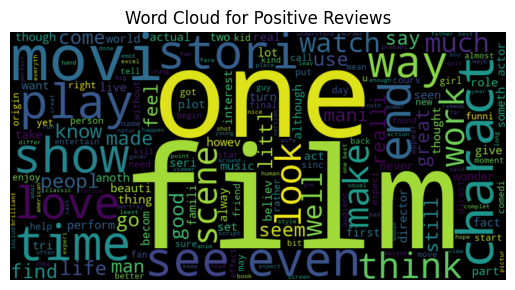

In [19]:
for label in [0, 1]:
    tokens = train_processed[train_processed['label'] == label]['processed_text']
    flat = " ".join([token for row in tokens for token in row])
    wordcloud = WordCloud(width=800, height=400).generate(flat)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {'Negative' if label==0 else 'Positive'} Reviews")
    plt.show()

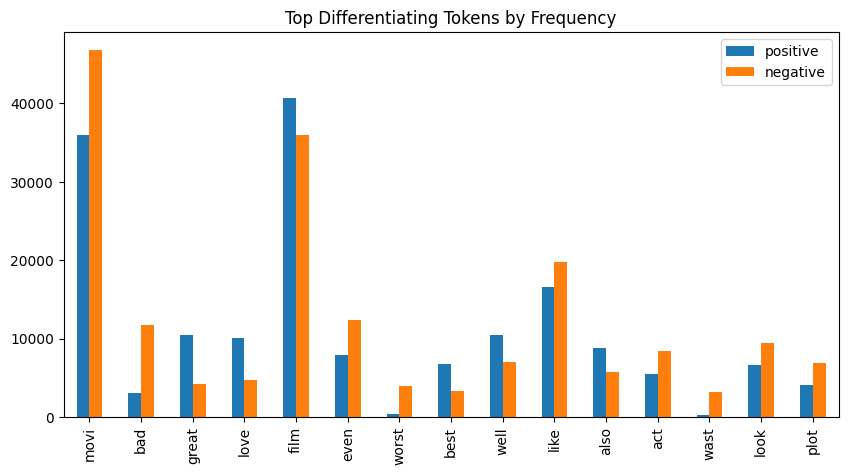

In [20]:
positive_counts = Counter([t for row in train_processed[train_processed['label'] == 1]['processed_text'] for t in row])
negative_counts = Counter([t for row in train_processed[train_processed['label'] == 0]['processed_text'] for t in row])

df_freq = pd.DataFrame({
    'positive': dict(positive_counts),
    'negative': dict(negative_counts)
}).fillna(0)

df_freq['diff'] = df_freq['positive'] - df_freq['negative']
top_diff = df_freq['diff'].abs().sort_values(ascending=False).head(15)

df_freq.loc[top_diff.index][['positive', 'negative']].plot(kind='bar', figsize=(10, 5))
plt.title("Top Differentiating Tokens by Frequency")
plt.show()

In [21]:
def get_ngrams_for_label(label, n=2):
    tokens = [token for row in train_processed[train_processed['label'] == label]['processed_text'] for token in row]
    n_grams = ngrams(tokens, n)
    return Counter(n_grams).most_common(10)

print("Positive Bigrams:", get_ngrams_for_label(1, 2))
print("Negative Bigrams:", get_ngrams_for_label(0, 2))

Positive Bigrams: [(('one', 'best'), 1361), (('watch', 'movi'), 1043), (('even', 'though'), 875), (('year', 'old'), 855), (('see', 'movi'), 826), (('look', 'like'), 782), (('first', 'time'), 778), (('ever', 'seen'), 772), (('highli', 'recommend'), 723), (('main', 'charact'), 688)]
Negative Bigrams: [(('look', 'like'), 2236), (('watch', 'movi'), 1475), (('ever', 'seen'), 1411), (('wast', 'time'), 1358), (('special', 'effect'), 1186), (('movi', 'ever'), 1069), (('year', 'old'), 1019), (('low', 'budget'), 1012), (('bad', 'movi'), 975), (('movi', 'like'), 910)]


Analysis directly for modeling

In [22]:
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 64036


In [23]:
valid_tokens = [t for row in valid_processed['processed_text'] for t in row]
test_tokens = [t for row in test_processed['processed_text'] for t in row]
train_top_10k = set([word for word, _ in Counter(all_tokens).most_common(10000)])
valid_oov_tokens = sum(1 for t in valid_tokens if t not in train_top_10k)
test_oov_tokens = sum(1 for t in test_tokens if t not in train_top_10k)
print(f"Valid OOV Tokens: {valid_oov_tokens} ({valid_oov_tokens / len(valid_tokens):.2%})")
print(f"Test OOV Tokens: {test_oov_tokens} ({test_oov_tokens / len(test_tokens):.2%})")

Valid OOV Tokens: 30688 (5.25%)
Test OOV Tokens: 31103 (5.25%)


High number OOV is concerning but they cover 5.25% of the whole dataset also further analysis below shows that 10k words hold 95% of cumulative coverage most of the OOV are very rare and can perhaps be overlooked

In [24]:
def analyze_lengths(df, data):
    lengths = df['processed_text'].apply(len)
    stats = {
        'Split': data,
        'Mean': lengths.mean(),
        'Median': lengths.median(),
        'Max': lengths.max(),
        '90th Percentile': np.percentile(lengths, 90),
        '95th Percentile': np.percentile(lengths, 95),
        '99th Percentile': np.percentile(lengths, 99),
    }
    return pd.DataFrame([stats])

train_stats = analyze_lengths(train_processed, "Train")
valid_stats = analyze_lengths(valid_processed, "Valid")
test_stats = analyze_lengths(test_processed, "Test")

length_stats_df = pd.concat([train_stats, valid_stats, test_stats], ignore_index=True)
length_stats_df

,Split,Mean,Median,Max,90th Percentile,95th Percentile,99th Percentile
0,Train,118.1877,88.0,1416,233.0,306.00,462.0
1,Valid,116.9274,86.0,794,231.0,305.05,450.0
2,Test,118.5712,88.0,1135,234.0,308.00,473.0


Coverage with top 1000 words: 66.73%
Coverage with top 5000 words: 89.50%
Coverage with top 10000 words: 95.00%
Coverage with top 15000 words: 97.11%
Coverage with top 20000 words: 98.15%
Coverage with top 30000 words: 99.08%


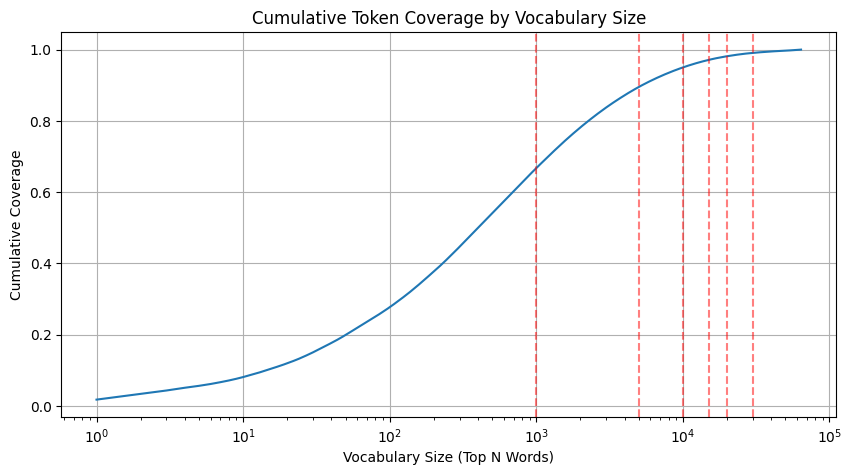

In [25]:
from itertools import accumulate

counts = [count for _, count in word_freq.most_common()]
cumulative_counts = list(accumulate(counts))
total_tokens = cumulative_counts[-1]

# O(1) : )
for n in [1000, 5000, 10000, 15000, 20000, 30000]:
    coverage = cumulative_counts[n - 1] / total_tokens
    print(f"Coverage with top {n} words: {coverage:.2%}")

counts = [count for _, count in word_freq.most_common()]
cumulative_counts = list(accumulate(counts))
total_tokens = cumulative_counts[-1]

# Normalize to percentage coverage
coverage = [count / total_tokens for count in cumulative_counts]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(coverage) + 1), coverage)
plt.xlabel("Vocabulary Size (Top N Words)")
plt.ylabel("Cumulative Coverage")
plt.title("Cumulative Token Coverage by Vocabulary Size")
for n in [1000, 5000, 10000, 15000, 20000, 30000]:
    plt.axvline(x=n, color='red', linestyle='--', alpha=0.5)
plt.grid(True)
plt.xscale('log')  # makes the curve easier to interpret
plt.show()

N-grams To generate or not to generate

Top Bigrams by Difference:
                   Positive  Negative      Diff
look    like          782.0    2236.0  0.000636
wast    time           72.0    1358.0  0.000554
one     best         1361.0     186.0  0.000487
worst   movi           18.0     900.0  0.000379
bad     movi          144.0     975.0  0.000359
one     worst          24.0     763.0  0.000318
ever    seen          772.0    1411.0  0.000285
highli  recommend     723.0      63.0  0.000274
movi    ever          510.0    1069.0  0.000247
        bad            84.0     638.0  0.000239
special effect        661.0    1186.0  0.000235
low     budget        485.0    1012.0  0.000233
must    see           616.0      86.0  0.000220
bad     act            48.0     553.0  0.000218
realli  bad            82.0     576.0  0.000213

Top Positive Bigrams:
                   Positive  Pos_Prop
one     best         1361.0  0.000567
watch   movi         1043.0  0.000434
even    though        875.0  0.000364
year    old           855.0  0

<Figure size 1200x600 with 0 Axes>

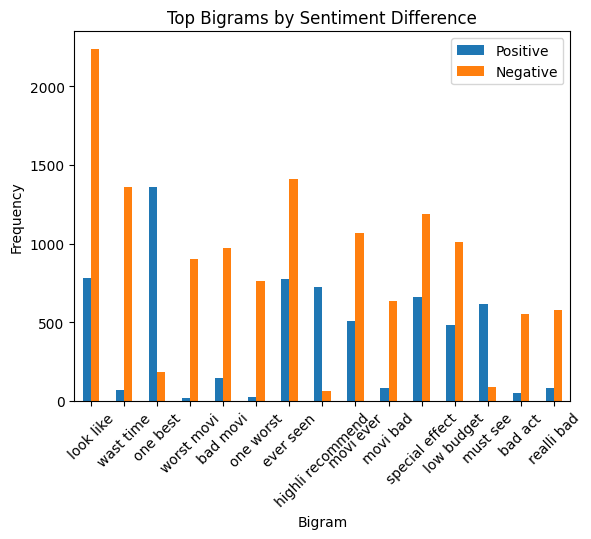

In [26]:
# Precompute tokens by label
positive_tokens = [t for row in train_processed[train_processed['label'] == 1]['processed_text'] for t in row]
negative_tokens = [t for row in train_processed[train_processed['label'] == 0]['processed_text'] for t in row]
all_tokens = positive_tokens + negative_tokens

# Function to get n-grams with frequency and difference
def analyze_ngrams(tokens_pos, tokens_neg, n, top_k=15):
    pos_ngrams = Counter(ngrams(tokens_pos, n))
    neg_ngrams = Counter(ngrams(tokens_neg, n))
    all_ngrams = Counter(ngrams(tokens_pos + tokens_neg, n))
    
    df_ngrams = pd.DataFrame({
        'Positive': dict(pos_ngrams),
        'Negative': dict(neg_ngrams),
        'Total': dict(all_ngrams)
    }).fillna(0)
    
    # Normalize
    pos_total = sum(pos_ngrams.values())
    neg_total = sum(neg_ngrams.values())
    df_ngrams['Pos_Prop'] = df_ngrams['Positive'] / pos_total
    df_ngrams['Neg_Prop'] = df_ngrams['Negative'] / neg_total
    
    # Absolute Difference  
    df_ngrams['Diff'] = (df_ngrams['Pos_Prop'] - df_ngrams['Neg_Prop']).abs()
    
    # Top by difference
    top_diff = df_ngrams.sort_values('Diff', ascending=False).head(top_k)
    top_pos = df_ngrams.sort_values('Pos_Prop', ascending=False).head(top_k)
    top_neg = df_ngrams.sort_values('Neg_Prop', ascending=False).head(top_k)
    
    return top_diff, top_pos, top_neg

# Bigrams
bigram_diff, bigram_pos, bigram_neg = analyze_ngrams(positive_tokens, negative_tokens, 2)
print("Top Bigrams by Difference:")
print(bigram_diff[['Positive', 'Negative', 'Diff']])
print("\nTop Positive Bigrams:")
print(bigram_pos[['Positive', 'Pos_Prop']])
print("\nTop Negative Bigrams:")
print(bigram_neg[['Negative', 'Neg_Prop']])

# Trigrams
trigram_diff, trigram_pos, trigram_neg = analyze_ngrams(positive_tokens, negative_tokens, 3)
print("\nTop Trigrams by Difference:")
print(trigram_diff[['Positive', 'Negative', 'Diff']])
print("\nTop Positive Trigrams:")
print(trigram_pos[['Positive', 'Pos_Prop']])
print("\nTop Negative Trigrams:")
print(trigram_neg[['Negative', 'Neg_Prop']])

# Visualize Top Bigrams by Difference
plt.figure(figsize=(12, 6))
bigram_diff[['Positive', 'Negative']].plot(kind='bar')
plt.title("Top Bigrams by Sentiment Difference")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.xticks(range(len(bigram_diff)), [f"{' '.join(x)}" for x in bigram_diff.index], rotation=45)
plt.show()

Overall the N-grams seem like they could be usefull in modeling the co-dependencies of tokens. YET since i am going to be testing sequential and Atention based models i would like to leave seeking these paterns to them in order to better evaluate their capabilities

***Vectorization***

In [27]:
preprocessor.build_vocabulary(train_processed['processed_text'], vocab_size=10000)

# Vectorize
train_vectors = preprocessor.vectorize(train_processed['processed_text'], max_length=300)
valid_vectors = preprocessor.vectorize(valid_processed['processed_text'], max_length=300)
test_vectors = preprocessor.vectorize(test_processed['processed_text'], max_length=300)

In [ ]:
train_labels = np.array(train_processed['label'])
valid_labels = np.array(valid_processed['label'])
test_labels = np.array(test_processed['label'])

print(f"Train Vectors Shape: {train_vectors.shape}")
print(f"Valid Vectors Shape: {valid_vectors.shape}")
print(f"Test Vectors Shape: {test_vectors.shape}")
print(f"Train Labels Shape: {train_labels.shape}")

Train Vectors Shape: (40000, 300)
Valid Vectors Shape: (5000, 300)
Test Vectors Shape: (5000, 300)
Train Labels Shape: (40000,)


In [29]:
print(f"Max index in train_vectors: {train_vectors.max()}")
print(f"Max index in valid_vectors: {valid_vectors.max()}")
print(f"Max index in test_vectors: {test_vectors.max()}")

Max index in train_vectors: 10000
Max index in valid_vectors: 9998
Max index in test_vectors: 10000


In [30]:
#Pytorch tensors
train_data = TensorDataset(torch.tensor(train_vectors, dtype=torch.long), torch.tensor(train_labels, dtype=torch.long))
valid_data = TensorDataset(torch.tensor(valid_vectors, dtype=torch.long), torch.tensor(valid_labels, dtype=torch.long))
test_data = TensorDataset(torch.tensor(test_vectors, dtype=torch.long), torch.tensor(test_labels, dtype=torch.long))

***Models***

In [ ]:
from Models.LSTM import UnidirectionalLSTM  
from Models.BiLSTM import BidirectionalLSTM 
from Models.AttentionBasedModel import AttentionBasedModel
from Models.Text_cnn import TextCNN

from utils.Trainer import Trainer
from utils.Visualizer import Visualizer
from utils.Compare_models import ModelComparator

In [32]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
save_dir = "Models"
os.makedirs(save_dir, exist_ok=True)

In [33]:
comparator = ModelComparator()

In [ ]:
models = [
    ("Unidirectional LSTM", UnidirectionalLSTM(vocab_size=10000, embedding_dim=100, hidden_dim=128, output_dim=2), 'Trained_models/uni_lstm.pt'),
    ("Bidirectional LSTM", BidirectionalLSTM(vocab_size=10000, embedding_dim=100, hidden_dim=128, output_dim=2), 'Trained_models/bi_lstm.pt'),
    ("Attention-Based Model", AttentionBasedModel(vocab_size=10000, embedding_dim=100, num_heads=4, hidden_dim=128, output_dim=2), 'Trained_models/attn_model.pt'),
    ("TextCNN", TextCNN(vocab_size=10000, embedding_dim=100, filter_sizes=[2, 3, 4], num_filters=128, output_dim=2), 'Trained_models/text_cnn.pt')
]

In [ ]:
for model_name, model in models:
    print(f"\nTraining {model_name}")
    start_time = time.time()
    trainer = Trainer(model, train_loader, valid_loader, test_loader, patience = 7, epochs= 25, lr = 0.001)
    trainer.train()
    end_time = time.time()
    train_losses, valid_losses, valid_accuracies, all_labels, all_preds, all_probs = trainer.get_metrics()
    comparator.add_model(model_name, train_losses, valid_losses, valid_accuracies, all_labels, all_preds, all_probs, end_time - start_time)


Training Unidirectional LSTM


Epoch 1/15
Train Loss: 0.6932
Valid Loss: 0.6930
Valid Accuracy: 0.5030


Epoch 2/15
Train Loss: 0.6915
Valid Loss: 0.6933
Valid Accuracy: 0.5034
No improvement for 1/5 epochs


Epoch 3/15
Train Loss: 0.6891
Valid Loss: 0.6938
Valid Accuracy: 0.5044
No improvement for 2/5 epochs


Epoch 4/15
Train Loss: 0.6868
Valid Loss: 0.6952
Valid Accuracy: 0.5046
No improvement for 3/5 epochs


Epoch 5/15
Train Loss: 0.6821
Valid Loss: 0.6998
Valid Accuracy: 0.5042
No improvement for 4/5 epochs


Epoch 6/15
Train Loss: 0.6780
Valid Loss: 0.7045
Valid Accuracy: 0.5074
No improvement for 5/5 epochs
Early stopping triggered after 6 epochs


Test Accuracy: 0.5036

Training Bidirectional LSTM


Epoch 1/15
Train Loss: 0.6101
Valid Loss: 0.5167
Valid Accuracy: 0.7500


Epoch 2/15
Train Loss: 0.4704
Valid Loss: 0.4710
Valid Accuracy: 0.7900


Epoch 3/15
Train Loss: 0.4231
Valid Loss: 0.3927
Valid Accuracy: 0.8238


Epoch 4/15
Train Loss: 0.3481
Valid Loss: 0.4024
Valid Accuracy: 0.8434
No improvement for 1/5 epochs


Epoch 5/15
Train Loss: 0.3090
Valid Loss: 0.3048
Valid Accuracy: 0.8716


Epoch 6/15
Train Loss: 0.2834
Valid Loss: 0.3040
Valid Accuracy: 0.8754


Epoch 7/15
Train Loss: 0.2652
Valid Loss: 0.2840
Valid Accuracy: 0.8772


Epoch 8/15
Train Loss: 0.2463
Valid Loss: 0.2976
Valid Accuracy: 0.8744
No improvement for 1/5 epochs


Epoch 9/15
Train Loss: 0.2380
Valid Loss: 0.3014
Valid Accuracy: 0.8880
No improvement for 2/5 epochs


Epoch 10/15
Train Loss: 0.2286
Valid Loss: 0.3106
Valid Accuracy: 0.8818
No improvement for 3/5 epochs


Epoch 11/15
Train Loss: 0.2115
Valid Loss: 0.2870
Valid Accuracy: 0.8870
No improvement for 4/5 epochs


Epoch 12/15
Train Loss: 0.1980
Valid Loss: 0.3118
Valid Accuracy: 0.8902
No improvement for 5/5 epochs
Early stopping triggered after 12 epochs


Test Accuracy: 0.8894

Training Attention-Based Model


Epoch 1/15
Train Loss: 0.4747
Valid Loss: 0.3729
Valid Accuracy: 0.8338


Epoch 2/15
Train Loss: 0.3585
Valid Loss: 0.3193
Valid Accuracy: 0.8644


Epoch 3/15
Train Loss: 0.3141
Valid Loss: 0.3005
Valid Accuracy: 0.8758


Epoch 4/15
Train Loss: 0.2875
Valid Loss: 0.2835
Valid Accuracy: 0.8830


Epoch 5/15
Train Loss: 0.2648
Valid Loss: 0.2775
Valid Accuracy: 0.8874


Epoch 6/15
Train Loss: 0.2531
Valid Loss: 0.2688
Valid Accuracy: 0.8868


Epoch 7/15
Train Loss: 0.2405
Valid Loss: 0.2761
Valid Accuracy: 0.8858
No improvement for 1/5 epochs


Epoch 8/15
Train Loss: 0.2302
Valid Loss: 0.2748
Valid Accuracy: 0.8876
No improvement for 2/5 epochs


Epoch 9/15
Train Loss: 0.2236
Valid Loss: 0.2716
Valid Accuracy: 0.8872
No improvement for 3/5 epochs


Epoch 10/15
Train Loss: 0.2155
Valid Loss: 0.2773
Valid Accuracy: 0.8874
No improvement for 4/5 epochs


Epoch 11/15
Train Loss: 0.2053
Valid Loss: 0.2832
Valid Accuracy: 0.8852
No improvement for 5/5 epochs
Early stopping triggered after 11 epochs


Test Accuracy: 0.8878

Training TextCNN


Epoch 1/15
Train Loss: 0.6583
Valid Loss: 0.4344
Valid Accuracy: 0.7994


Epoch 2/15
Train Loss: 0.5046
Valid Loss: 0.3714
Valid Accuracy: 0.8354


Epoch 3/15
Train Loss: 0.4564
Valid Loss: 0.3355
Valid Accuracy: 0.8530


Epoch 4/15
Train Loss: 0.4173
Valid Loss: 0.3196
Valid Accuracy: 0.8642


Epoch 5/15
Train Loss: 0.3911
Valid Loss: 0.3186
Valid Accuracy: 0.8616


Epoch 6/15
Train Loss: 0.3768
Valid Loss: 0.2939
Valid Accuracy: 0.8724


Epoch 7/15
Train Loss: 0.3594
Valid Loss: 0.2902
Valid Accuracy: 0.8790


Epoch 8/15
Train Loss: 0.3481
Valid Loss: 0.2961
Valid Accuracy: 0.8708
No improvement for 1/5 epochs


Epoch 9/15
Train Loss: 0.3358
Valid Loss: 0.3066
Valid Accuracy: 0.8728
No improvement for 2/5 epochs


Epoch 10/15
Train Loss: 0.3310
Valid Loss: 0.2840
Valid Accuracy: 0.8810


Epoch 11/15
Train Loss: 0.3171
Valid Loss: 0.2822
Valid Accuracy: 0.8780


Epoch 12/15
Train Loss: 0.3053
Valid Loss: 0.3202
Valid Accuracy: 0.8688
No improvement for 1/5 epochs


Epoch 13/15
Train Loss: 0.2953
Valid Loss: 0.2991
Valid Accuracy: 0.8736
No improvement for 2/5 epochs


Epoch 14/15
Train Loss: 0.2890
Valid Loss: 0.2801
Valid Accuracy: 0.8836


Epoch 15/15
Train Loss: 0.2775
Valid Loss: 0.2838
Valid Accuracy: 0.8846
No improvement for 1/5 epochs


Test Accuracy: 0.8812



Model Comparison Summary:
                   Model  Test Accuracy       AUC  Final Train Loss  \
0    Unidirectional LSTM         0.5036  0.504770          0.678001   
1     Bidirectional LSTM         0.8894  0.955069          0.197968   
2  Attention-Based Model         0.8878  0.953496          0.205327   
3                TextCNN         0.8812  0.949806          0.277463   

   Final Valid Loss  Final Valid Accuracy  Training Time (s)  
0          0.704486                0.5074        4624.078077  
1          0.311755                0.8902       15829.165844  
2          0.283230                0.8852        1766.212059  
3          0.283792                0.8846        1583.453355  


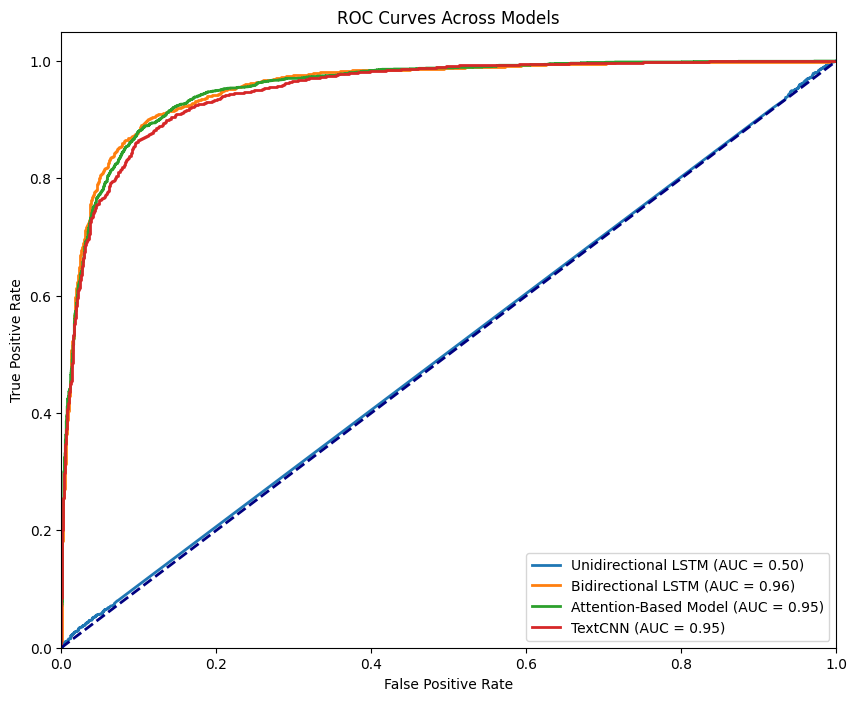

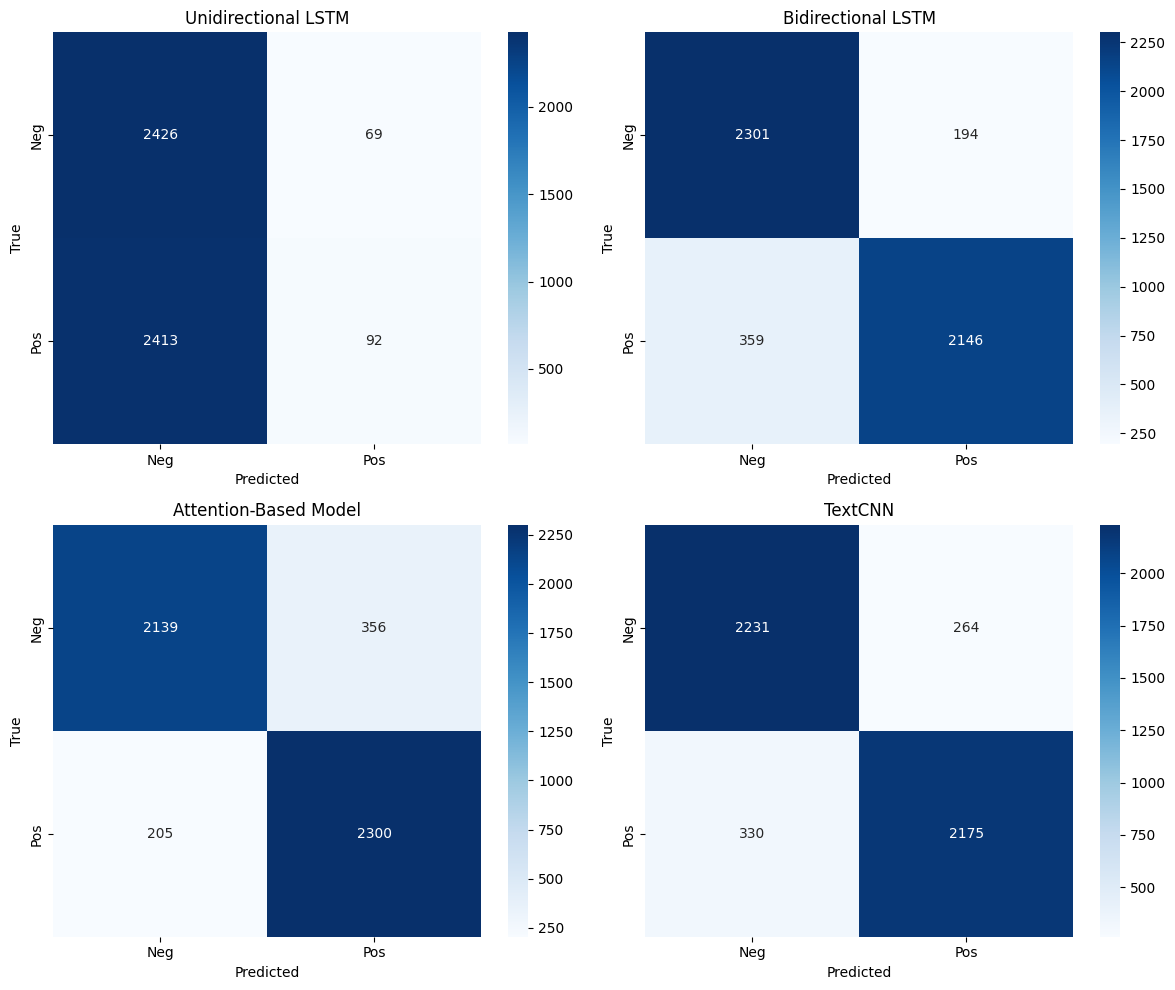

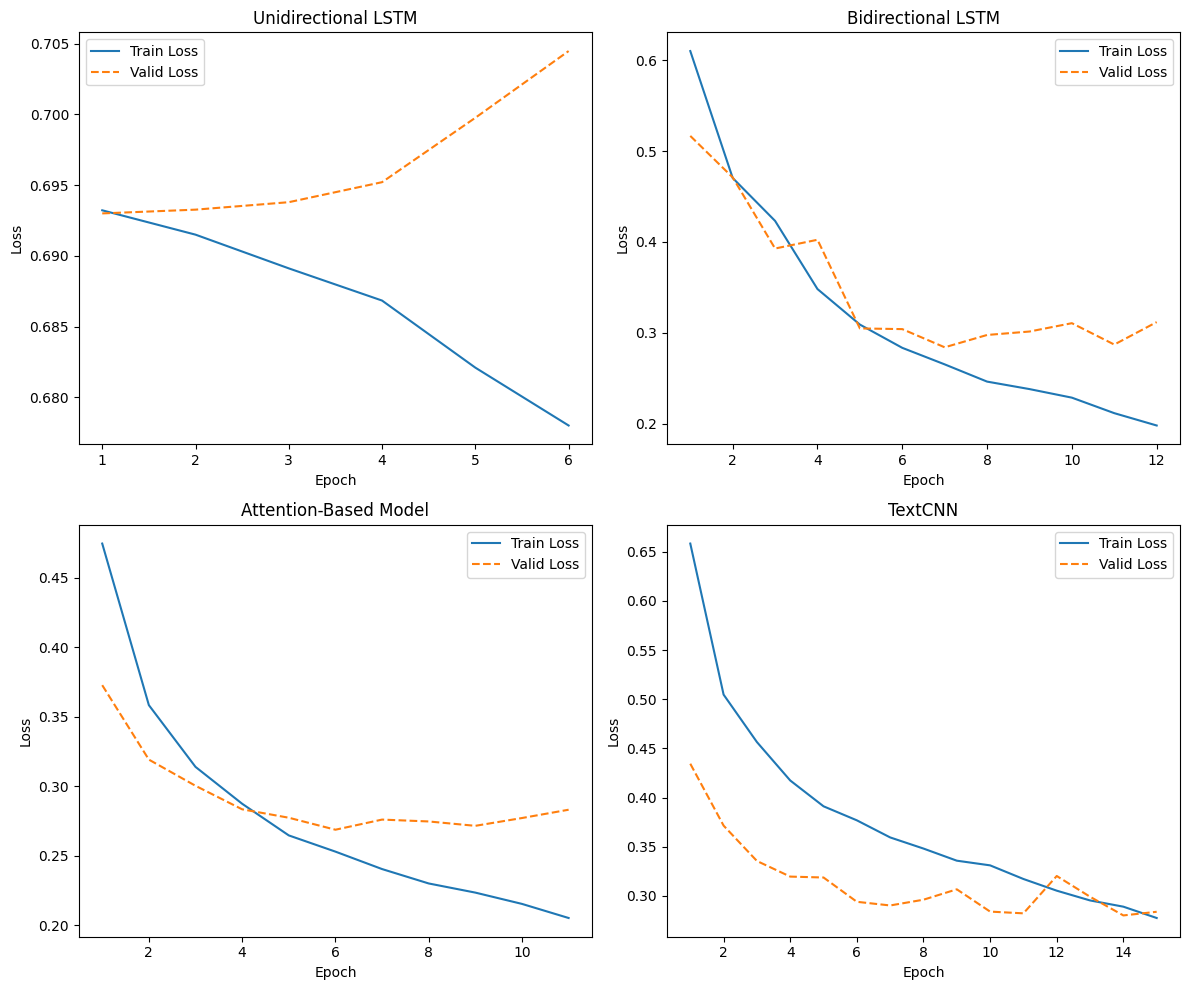

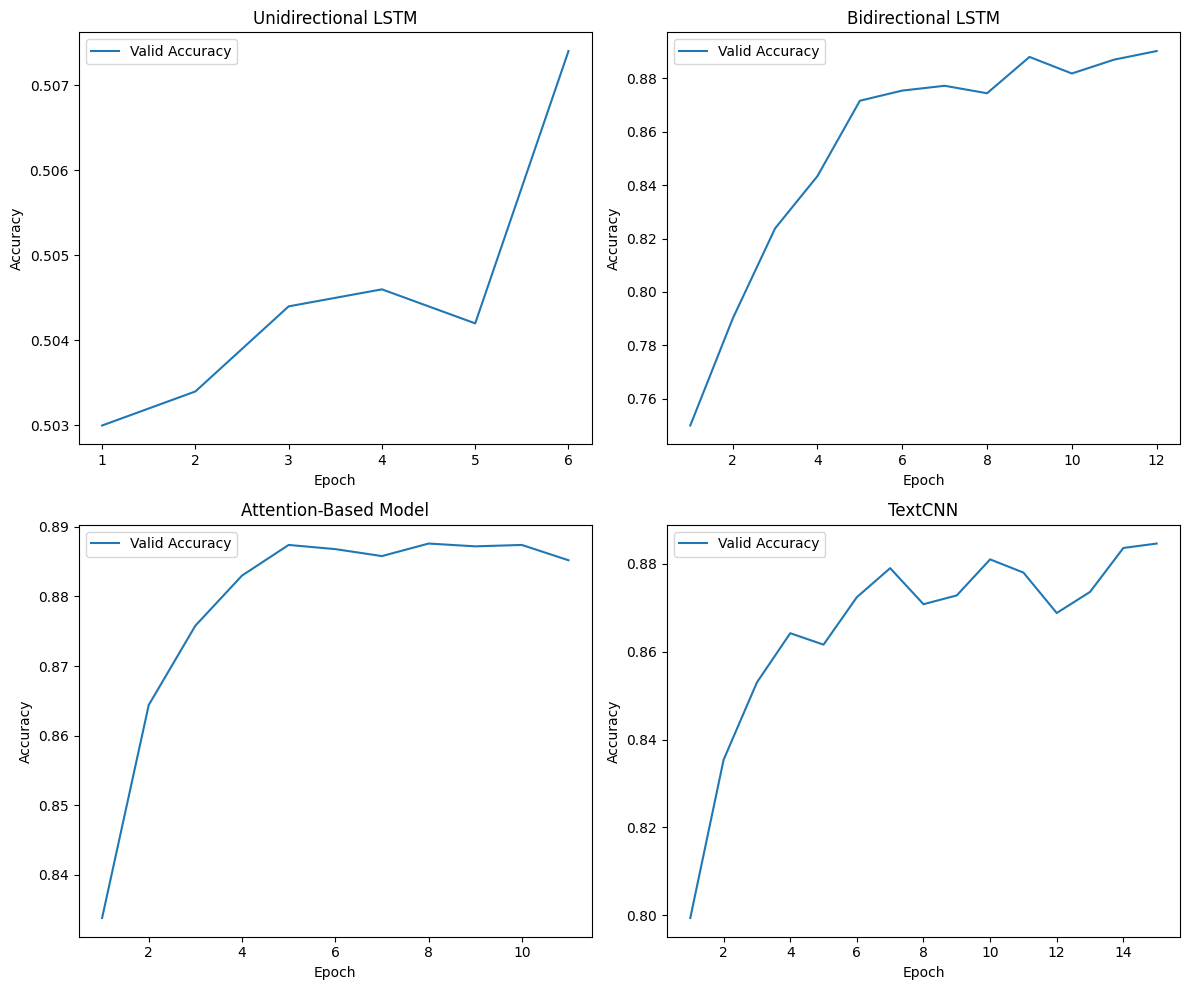

In [37]:
summary_table=comparator.plot_all()

In [38]:
summary_table

,Model,Test Accuracy,AUC,Final Train Loss,Final Valid Loss,Final Valid Accuracy,Training Time (s)
0,Unidirectional LSTM,0.5036,0.504770,0.678001,0.704486,0.5074,4624.078077
1,Bidirectional LSTM,0.8894,0.955069,0.197968,0.311755,0.8902,15829.165844
2,Attention-Based Model,0.8878,0.953496,0.205327,0.283230,0.8852,1766.212059
3,TextCNN,0.8812,0.949806,0.277463,0.283792,0.8846,1583.453355
